# Multi-Modal on PDF's with table transformer and GPT4-V.


One common challenge with RAG (`Retrieval-Augmented Generation`) involves handling PDFs that contain tables. Parsing tables in various formats can be quite complex.

However, Microsoft's newly released model, [`Table Transformer`](https://huggingface.co/microsoft/table-transformer-detection), offers a promising solution for detecting tables within images.

In this notebook, we will demonstrate how to leverage the `Table Transformer` model in conjunction with GPT4-V to yield better results for images containing tables.

The experiment is divided into the following parts and we compared those 4 options for extracting table information from PDFs:

1. Retrieving relevant images (PDF pages) and sending them to GPT4-V to respond to queries.
2. Regarding every PDF page as an image, let GPT4-V do the image reasoning for each page. Build Text Vector Store index for the image reasonings. Query the answer against the `Image Reasoning Vectore Store`.
3. Using `Table Transformer` to crop the table information from the retrieved images and then sending these cropped images to GPT4-V for query responses.
4. Applying OCR on cropped table images and send the data to GPT4/ GPT-3.5 to answer the query.

#### Setup

In [2]:
# !pip install llama-index qdrant_client pyMuPDF tools frontend git+https://github.com/openai/CLIP.git easyocr

In [3]:
!pip install llama-index qdrant_client

In [4]:
!pip install matplotlib 

In [5]:
!pip install pillow

In [6]:
!pip install pyMuPDF

In [7]:
# !pip install tools

In [8]:
# !pip install frontend 

In [9]:
# !pip install git+https://github.com/openai/CLIP.git 

  Cloning https://github.com/openai/CLIP.git to c:\users\prajod\appdata\local\temp\pip-req-build-ek664gn_
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\Prajod\AppData\Local\Temp\pip-req-build-ek664gn_'


In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
import io
from PIL import Image, ImageDraw
import numpy as np
import csv
import pandas as pd

# from torchvision import transforms

# from transformers import AutoModelForObjectDetection
# import torch
import openai
import os
import fitz



In [11]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
!pip install python-dotenv

In [34]:
from dotenv import load_dotenv
import os

load_dotenv()
openai.api_key = os.getenv('OPENAI_API_KEY')
OPENAI_API_TOKEN = openai.api_key

# OPENAI_API_TOKEN = "sk-<your-openai-api-token>"
# openai.api_key = OPENAI_API_TOKEN

Download Llama2 paper for the experiments.

In [14]:
# !wget --user-agent "Mozilla" "https://arxiv.org/pdf/2307.09288.pdf" -O "llama2.pdf"

Here we convert each of the Llama2 paper pdf page to images for indexing.

In [15]:
pdf_file = "llama2.pdf"

# Split the base name and extension
output_directory_path, _ = os.path.splitext(pdf_file)

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

# Open the PDF file
pdf_document = fitz.open(pdf_file)

# Iterate through each page and convert to an image
for page_number in range(pdf_document.page_count):
    # Get the page
    page = pdf_document[page_number]

    # Convert the page to an image
    pix = page.get_pixmap()

    # Create a Pillow Image object from the pixmap
    image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    # Save the image
    image.save(f"./{output_directory_path}/page_{page_number + 1}.png")

# Close the PDF file
pdf_document.close()

Display the images.

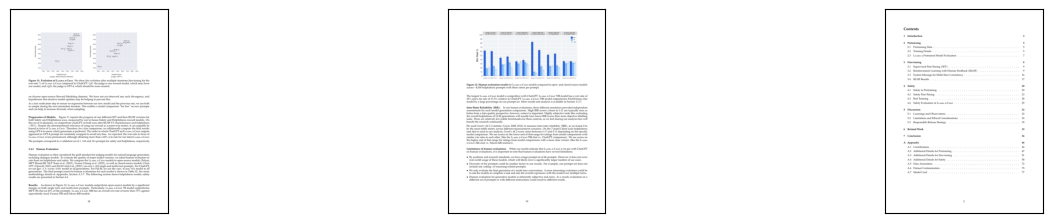

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./llama2"):
    image_paths.append(str(os.path.join("./llama2", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths[9:12])

## Experiment-1: Retrieving relevant images (PDF pages) and sending them to GPT4-V to respond to queries.

## Experiment-2: Parse each pdf page as an image and get table date directly from GPT4-V. Index tables data and then do text retrieval

Steps:
- Extract and separate each PDF page as an image document
- Let GPT4V identify table and extract table information from each PDF page
- Index GPT4V understandings for each page into `Image Reasoning Vector Store`
- Retrieve answer from this `Image Reasoning Vector Store`

## Experiment-3: Let's use microsoft `Table Transformer` to crop tables from the images and see if it gives the correct answer.

Thanks to [Neils](https://twitter.com/NielsRogge). We have modified the utils from the [repository](https://huggingface.co/spaces/nielsr/tatr-demo) for our task.

In [17]:
!pip install torchvision

In [18]:
!pip install torch

In [19]:
!pip install transformers

In [20]:
!pip install ipywidgets widgetsnbextension pandas-profiling

In [21]:
from torchvision import transforms
from transformers import AutoModelForObjectDetection

import torch

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize(
            (int(round(scale * width)), int(round(scale * height)))
        )

        return resized_image


detection_transform = transforms.Compose(
    [
        MaxResize(800),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

structure_transform = transforms.Compose(
    [
        MaxResize(1000),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# load table detection model
# processor = TableTransformerImageProcessor(max_size=800)
model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-detection", revision="no_timm"
).to(device)

# load table structure recognition model
# structure_processor = TableTransformerImageProcessor(max_size=1000)
structure_model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-structure-recognition-v1.1-all"
).to(device)


# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    width, height = size
    boxes = box_cxcywh_to_xyxy(out_bbox)
    boxes = boxes * torch.tensor(
        [width, height, width, height], dtype=torch.float32
    )
    return boxes


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs["pred_boxes"].detach().cpu()[0]
    pred_bboxes = [
        elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)
    ]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == "no object":
            objects.append(
                {
                    "label": class_label,
                    "score": float(score),
                    "bbox": [float(elem) for elem in bbox],
                }
            )

    return objects


def detect_and_crop_save_table(
    file_path, cropped_table_directory="./table_images/"
):
    image = Image.open(file_path)

    filename, _ = os.path.splitext(file_path.split("/")[-1])

    if not os.path.exists(cropped_table_directory):
        os.makedirs(cropped_table_directory)

    # prepare image for the model
    # pixel_values = processor(image, return_tensors="pt").pixel_values
    pixel_values = detection_transform(image).unsqueeze(0).to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values)

    # postprocess to get detected tables
    id2label = model.config.id2label
    id2label[len(model.config.id2label)] = "no object"
    detected_tables = outputs_to_objects(outputs, image.size, id2label)

    print(f"number of tables detected {len(detected_tables)}")

    for idx in range(len(detected_tables)):
        #   # crop detected table out of image
        cropped_table = image.crop(detected_tables[idx]["bbox"])
        cropped_table.save(f"./{cropped_table_directory}/{filename}_{idx}.png")


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

In [24]:
from llama_index import (
    SimpleDirectoryReader,
)

In [25]:
import qdrant_client
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index import StorageContext
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex

In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\prajod\appdata\local\temp\pip-req-build-d2bop0b8
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/53.4 kB ? eta -:--:--
   ---------------------------------------- 53.4/53.4 kB 1.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369578 sha256=c1e772bb3c50f2d4900367c9e6ff18e7961cebff6cb251b82965e37654733862
  Stored in directory: C:\Users\Prajod\AppData\Local\Temp\pip-ephem-wheel-cache-u3z452uk\wheels\3f\7c\a4\9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.5
    Uninstalling wcwidth-0.2.5:
      Successfully uninstalled wcwidth-0.2.5


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\Prajod\AppData\Local\Temp\pip-req-build-d2bop0b8'


In [26]:
# Read the images
documents_images = SimpleDirectoryReader("./llama2/").load_data()

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_index")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
index = MultiModalVectorStoreIndex.from_documents(
    documents_images,
    storage_context=storage_context,
)

retriever_engine = index.as_retriever(image_similarity_top_k=2)

100%|███████████████████████████████████████| 338M/338M [01:14<00:00, 4.75MiB/s]


In [27]:
from llama_index.indices.multi_modal.retriever import (
    MultiModalVectorIndexRetriever,
)

query = "Compare llama2 with llama1?"
assert isinstance(retriever_engine, MultiModalVectorIndexRetriever)
# retrieve for the query using text to image retrieval
retrieval_results = retriever_engine.text_to_image_retrieve(query)

In [28]:
from llama_index.schema import ImageNode
from llama_index.response.notebook_utils import display_source_node

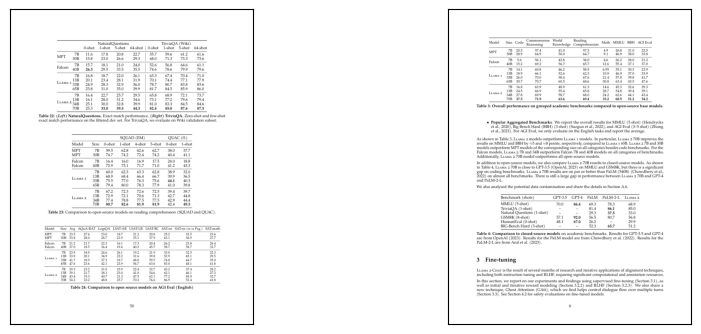

In [29]:
retrieved_images = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_images.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_images)

Crop the tables

In [31]:
for file_path in retrieved_images:
    detect_and_crop_save_table(file_path)

number of tables detected 3
number of tables detected 2


In [33]:
# Read the cropped tables
image_documents = SimpleDirectoryReader("./table_images/llama2").load_data()

Generate response for the query.

In [35]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

In [36]:
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1500
)

In [37]:
# response = openai_mm_llm.complete(
#     prompt="Compare llama2 with llama1?",
#     image_documents=image_documents,
# )

# print(response)

The tables you've provided seem to be comparing the performance of various machine learning models on different benchmarks and tasks. The models are referred to as "MPT," "Falcon," "LLama 1," and "LLama 2," with different sizes denoted by "7B," "13B," "30B," "40B," and "65B," which likely refer to the number of parameters in each model (billions).

To compare "LLama 2" with "LLama 1," we would look at the scores across the various tasks and benchmarks. Here's a summary based on the data provided:

- On the SQuAD benchmark, "LLama 2" generally outperforms "LLama 1" across different shots (0-shot, 1-shot, 4-shot, 5-shot, and 64-shot), indicating better performance in question-answering tasks based on the SQuAD dataset.
- For the QUAC benchmark, "LLama 2" also shows higher scores than "LLama 1" in most cases, suggesting better conversational question-answering capabilities.
- In the Natural Questions and TriviaQA benchmarks, "LLama 2" again has higher scores than "LLama 1," indicating a s

In [ ]:
import glob

table_images_paths = glob.glob("./table_images/*.png")

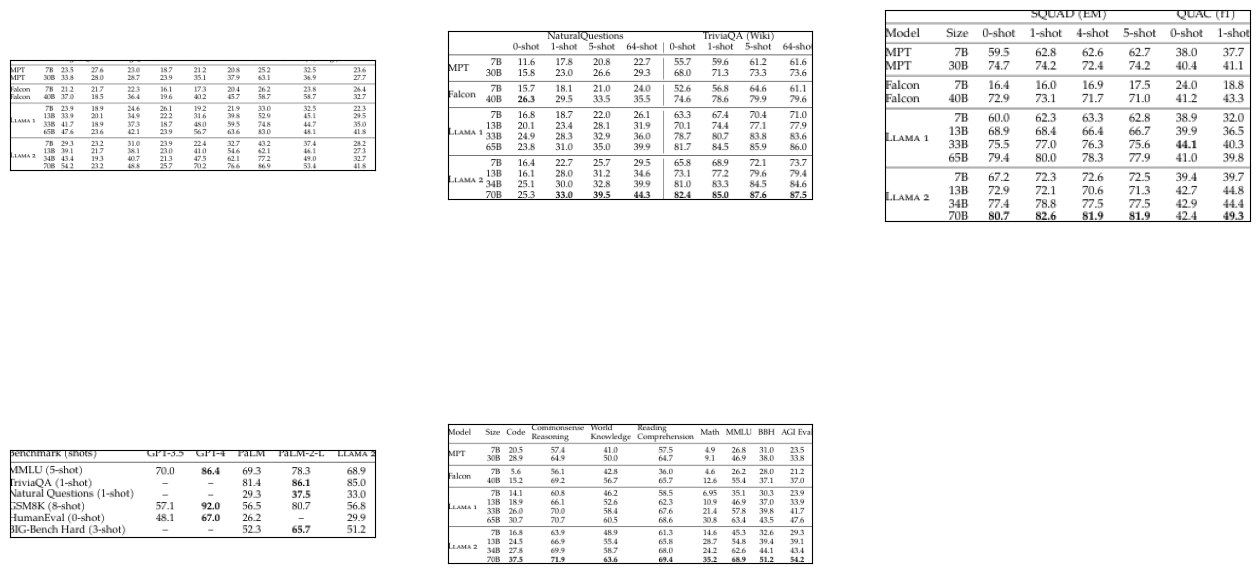

In [ ]:
plot_images(table_images_paths)

In [38]:
response = openai_mm_llm.complete(
    prompt="What are the sizes of the Falcon models",
    image_documents=image_documents,
)

print(response)

The tables you've provided contain information about various language models and their performance on different benchmarks. The sizes of the Falcon models mentioned in the tables are:

- Falcon 7B: This model has 7 billion parameters.
- Falcon 40B: This model has 40 billion parameters.

The "B" in the model size typically stands for "billion," indicating the number of parameters in the model. Parameters are the aspects of the model that are learned from training data and determine the model's behavior. Generally, models with more parameters have a greater capacity to learn and can potentially perform better on complex tasks, assuming they are trained effectively.


In [39]:
response = openai_mm_llm.complete(
    prompt="What is the performance of LLama 2 34B on the 5-shot Natural Questions",
    image_documents=image_documents,
)

print(response)

The performance of the LLama 2 34B model on the 5-shot Natural Questions benchmark is 39.5% for Exact Match (EM). This is shown in the third table, under the "NaturalQuestions" column and the "5-shot" row for the LLama 2 34B model.


In [40]:
response = openai_mm_llm.complete(
    prompt="What is the performance of LLama 2 70B on the 5-shot Natural Questions",
    image_documents=image_documents,
)

print(response)

The performance of the LLama 2 70B model on the 5-shot Natural Questions benchmark is 39.5% for Exact Match (EM). This is shown in the third table provided, under the "NaturalQuestions" section. The 5-shot setting indicates that the model was given five examples to learn from before being tested on the benchmark.


In [41]:
response = openai_mm_llm.complete(
    prompt="What is the performance of Falcon  40B on the 5-shot Natural Questions",
    image_documents=image_documents,
)

print(response)

The performance of Falcon 40B on the 5-shot Natural Questions is 71.0 in Exact Match (EM) as shown in the first table.


In [42]:
response = openai_mm_llm.complete(
    prompt="What is the performance of LLama 2 7B on the Natural Questions ?",
    image_documents=image_documents,
)

print(response)

The performance of the LLama 2 7B model on the Natural Questions benchmark is as follows:

- 0-shot: 33.0%
- 1-shot: 39.5%
- 5-shot: 44.3%
- 64-shot: 48.4%

These numbers represent the percentage of questions that the model answered correctly in each scenario, with "0-shot" meaning no examples were given before the test, "1-shot" meaning one example was given, and so on. The performance generally improves with more examples provided, indicating that the model learns from the additional context.


In [43]:
response = openai_mm_llm.complete(
    prompt="Can you see that  the performance of LLama 2 7B on the Natural Questions are 16.4, 22.7, 25.7 and 29.5 ?",
    image_documents=image_documents,
)

print(response)

Yes, according to the tables provided, the performance of the LLama 2 model with 7B parameters on the Natural Questions benchmark is as follows:

- 0-shot: 33.0
- 1-shot: 39.5
- 5-shot: 44.3
- 64-shot: 48.4

These scores represent the model's performance across different numbers of example prompts or "shots" given to the model before it attempts to answer questions from the Natural Questions dataset.


### Observation:
 As demonstrated, the model now provides accurate answers. This aligns with our findings from the Chain of Thought (COT) experiments, where supplying GPT-4-V with specific image information significantly enhances its ability to deliver correct responses.

## Experiment-4: Applying OCR on cropped table images and send the data to GPT4/ GPT-3.5 to answer the query.

The experiment depends highly on the OCR model used. Here we are using easyocr with few modifications from [repository](https://huggingface.co/spaces/nielsr/tatr-demo).

## Conclusion

In this notebook we have explored different ways of handling table information present in PDF's. Specifically we explored Microsoft `Table Transformer` to crop tables from images and process it to get accurate answer.